In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# load the sales data set
sales_data = pd.read_csv('../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Skincare'] 

pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 1,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
17,1-12-2015,12,4,2015,1,Foundation 2,Skincare,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
18,1-12-2015,12,4,2015,2,Facemask,Skincare,Pharmacy 2,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
47,1-1-2016,1,1,2016,1,Facemask,Skincare,Pharmacy 2,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
48,1-1-2016,1,1,2016,1,Facemask,Skincare,Pharmacy 2,SouthEast,0,...,0,0,0,0,0,0,0,0,1,0
49,1-1-2016,1,1,2016,1,Facemask,Skincare,Pharmacy 2,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68631,1-3-2022,3,1,2022,2,Facemask,Skincare,Pharmacy 5,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
68632,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
68633,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,London,0,...,0,0,1,0,0,0,0,0,0,0
68634,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,London,0,...,0,0,1,0,0,0,0,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 11',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 6',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Cream 1',
 'Cream 2',
 'Cream 3',
 'Cream 4',
 'Facemask',
 'Foundation 1',
 'Foundation 2',
 'Make-up Remover',
 'Pills',
 'sunblock',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 6' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Pharmacy 11' : 'sum',
    'Cream 1' : 'sum',
    'Cream 2' : 'sum',
    'Cream 3' : 'sum',
    'Cream 4' : 'sum',
    'Facemask' : 'sum',
    'Foundation 1' : 'sum',
    'Foundation 2' : 'sum',
    'Make-up Remover' : 'sum',
    'Pills' : 'sum',
    'sunblock' : 'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

#print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)


# split the data into training and testing sets
train_size = int(len(sales_data_lagged) * 0.8)
train_data = sales_data_lagged[:train_size]
test_data = sales_data_lagged[train_size:]


In [4]:
# train an mlp classifier

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']

random_grid_mlpr = {
    'activation' : activation,
    'solver' : solver
}

# mlpr = MLPRegressor()
# mlpr_random = RandomizedSearchCV(
#     estimator=mlpr,
#     param_distributions=random_grid_mlpr,
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     random_state=0
# )
mlpr = MLPRegressor()
mlpr_random = GridSearchCV(
    estimator=mlpr,
    param_grid=random_grid_mlpr,
    cv=5,
    verbose=5
)

In [5]:
mlpr_random.fit(train_data.iloc[:, 2:], train_data['Qty'])


# make predictions for the test data
predictions = mlpr_random.predict(test_data.iloc[:, 2:])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=identity, solver=lbfgs;, score=0.830 total time=   0.2s
[CV 2/5] END .activation=identity, solver=lbfgs;, score=0.903 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .activation=identity, solver=lbfgs;, score=0.875 total time=   0.0s
[CV 4/5] END .activation=identity, solver=lbfgs;, score=0.953 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maxi

[CV 5/5] END .activation=identity, solver=lbfgs;, score=0.912 total time=   0.0s
[CV 1/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 2/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 3/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py

[CV 4/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 5/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 1/5] END ..activation=identity, solver=adam;, score=0.794 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ..activation=identity, solver=adam;, score=0.970 total time=   0.0s
[CV 3/5] END ..activation=identity, solver=adam;, score=0.966 total time=   0.0s
[CV 4/5] END ..activation=identity, solver=adam;, score=0.938 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END ..activation=identity, solver=adam;, score=0.978 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=logistic, solver=lbfgs;, score=0.022 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .activation=logistic, solver=lbfgs;, score=0.708 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, solver=lbfgs;, score=-0.678 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, solver=lbfgs;, score=-0.084 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END .activation=logistic, solver=lbfgs;, score=0.297 total time=   0.2s
[CV 1/5] END ...activation=logistic, solver=sgd;, score=0.051 total time=   0.0s
[CV 2/5] END ...activation=logistic, solver=sgd;, score=0.022 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ..activation=logistic, solver=sgd;, score=-0.095 total time=   0.0s
[CV 4/5] END ..activation=logistic, solver=sgd;, score=-0.081 total time=   0.0s
[CV 5/5] END ...activation=logistic, solver=sgd;, score=0.011 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END .activation=logistic, solver=adam;, score=-1.554 total time=   0.0s
[CV 2/5] END .activation=logistic, solver=adam;, score=-0.597 total time=   0.0s
[CV 3/5] END .activation=logistic, solver=adam;, score=-1.323 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .activation=logistic, solver=adam;, score=-0.464 total time=   0.0s
[CV 5/5] END .activation=logistic, solver=adam;, score=-0.638 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .....activation=tanh, solver=lbfgs;, score=0.142 total time=   0.1s
[CV 2/5] END .....activation=tanh, solver=lbfgs;, score=0.224 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END ....activation=tanh, solver=lbfgs;, score=-0.055 total time=   0.1s
[CV 4/5] END .....activation=tanh, solver=lbfgs;, score=0.196 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .....activation=tanh, solver=lbfgs;, score=0.205 total time=   0.1s
[CV 1/5] END .......activation=tanh, solver=sgd;, score=0.356 total time=   0.0s
[CV 2/5] END .......activation=tanh, solver=sgd;, score=0.504 total time=   0.0s
[CV 3/5] END .......activation=tanh, solver=sgd;, score=0.348 total time=   0.0s
[CV 4/5] END ......activation=tanh, solver=sgd;, score=-0.396 total time=   0.0s
[CV 5/5] END .......activation=tanh, solver=sgd;, score=0.080 total time=   0.0s
[CV 1/5] END .....activation=tanh, solver=adam;, score=-1.541 total time=   0.0s
[CV 2/5] END .....activation=tanh, solver=adam;, score=-0.589 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .....activation=tanh, solver=adam;, score=-1.334 total time=   0.0s
[CV 4/5] END .....activation=tanh, solver=adam;, score=-0.457 total time=   0.0s
[CV 5/5] END .....activation=tanh, solver=adam;, score=-0.640 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs f

[CV 1/5] END .....activation=relu, solver=lbfgs;, score=0.700 total time=   0.0s
[CV 2/5] END .....activation=relu, solver=lbfgs;, score=0.940 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .....activation=relu, solver=lbfgs;, score=0.948 total time=   0.0s
[CV 4/5] END .....activation=relu, solver=lbfgs;, score=0.838 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .....activation=relu, solver=lbfgs;, score=0.961 total time=   0.0s
[CV 1/5] END activation=relu, solver=sgd;, score=-394907968190557.125 total time=   0.0s
[CV 2/5] END activation=relu, solver=sgd;, score=-12608245239779546568768237274165936128.000 total time=   0.0s
[CV 3/5] END .activation=relu, solver=sgd;, score=-674597.748 total time=   0.0s
[CV 4/5] END activation=relu, solver=sgd;, score=-1592453283415567827292050027158719269030606067990528.000 total time=   0.0s
[CV 5/5] END .activation=relu, solver=sgd;, score=-242016.334 total time=   0.0s
[CV 1/5] END ......activation=relu, solver=adam;, score=0.678 total time=   0.0s
[CV 2/5] END ......activation=relu, solver=adam;, score=0.963 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_s

[CV 3/5] END ......activation=relu, solver=adam;, score=0.889 total time=   0.0s
[CV 4/5] END ......activation=relu, solver=adam;, score=0.838 total time=   0.0s
[CV 5/5] END ......activation=relu, solver=adam;, score=0.957 total time=   0.0s


In [6]:
# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - test_data['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

# calculate the mean squared error
mse = mean_squared_error(test_data['Qty'], predictions)
print('MSE:', mse)

# calculate the r2 score
r2_score = r2_score(test_data['Qty'], predictions)
print('R^2 Score:', r2_score)

# calculate explained variance score
explained_variance_score = explained_variance_score(test_data['Qty'], predictions)
print('Explained Variance Score:', explained_variance_score)

# calculate max error
max_error = max_error(test_data['Qty'], predictions)
print('Max Error:', max_error)


print([test_data['Date'].values, test_data['Qty'].values, predictions])

RMSE: 45.28750086059862
MSE: 2050.957734198721
R^2 Score: 0.9386660813976399
Explained Variance Score: 0.9398820679976707
Max Error: 88.51588609783863
[array(['1-7-2020', '1-7-2021', '1-8-2016', '1-8-2017', '1-8-2018',
       '1-8-2019', '1-8-2020', '1-8-2021', '1-9-2016', '1-9-2017',
       '1-9-2018', '1-9-2019', '1-9-2020', '1-9-2021'], dtype=object), array([445, 344,  20,  26,  46, 236, 477, 353,  42,   3,  72, 305, 534,
       288], dtype=int64), array([510.44299201, 432.5158861 , -29.69455241,  32.54149749,
        89.98622352, 217.17792793, 454.65423637, 308.56019678,
        -7.16199745,   9.20970165,  76.61675844, 252.84701821,
       469.90461091, 284.12643882])]


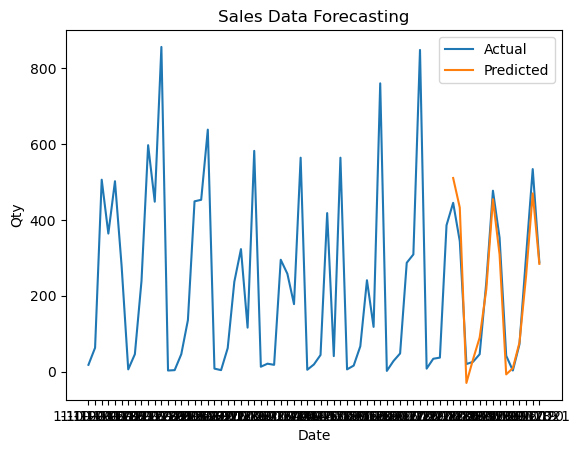

In [7]:
sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=test_data.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [8]:
mlpr_random.best_params_

{'activation': 'identity', 'solver': 'adam'}

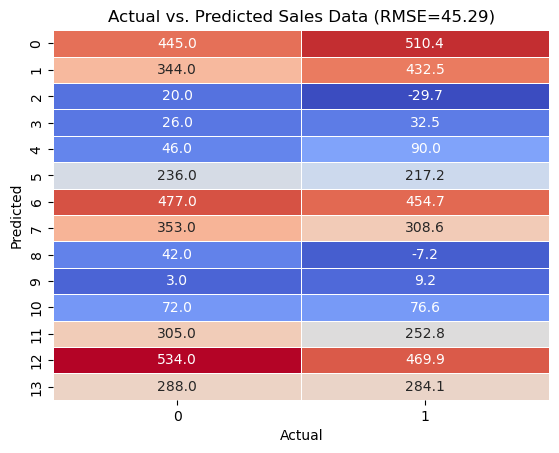

In [9]:
matrix_data = np.column_stack((test_data['Qty'].values, predictions))

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()